In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.float_format", lambda x: f"{x:,.2f}")
sns.set(style="whitegrid", context="talk")

In [53]:
data_path = "C://Users//aditi//OneDrive//Desktop//fraud_detection//fraud_data - Sheet 1.csv"
df = pd.read_csv(data_path)
df.head()

,TransactionID,Amount,Time,Location,MerchantCategory,CardHolderAge,IsFraud
0,1,375.17,47605,Houston,Travel,18.00,0
1,2,950.76,38088,Los Angeles,Electronics,28.00,0
2,3,732.26,78752,Miami,Travel,20.00,0
3,4,599.06,55284,New York,Groceries,69.00,0
4,5,156.86,57043,New York,Groceries,79.00,0


In [54]:
total_txns = len(df)
fraud_rate = df["IsFraud"].mean() * 100
total_fraud_loss = df.loc[df["IsFraud"] == 1, "Amount"].sum()

top_category = (
    df.groupby("MerchantCategory")["IsFraud"]
    .mean()
    .sort_values(ascending=False)
    .index[0]
)

total_txns, fraud_rate, total_fraud_loss, top_category

(500, 5.4, 11382.17, 'Clothing')

In [55]:
fraud_rate


5.4

In [56]:
fraud_by_category = (
    df.groupby("MerchantCategory")["IsFraud"]
    .mean()
    .sort_values(ascending=False) * 100
)
fraud_by_category

MerchantCategory
Clothing        7.69
Groceries       7.27
Entertainment   4.59
Travel          4.00
Electronics     3.88
Name: IsFraud, dtype: float64

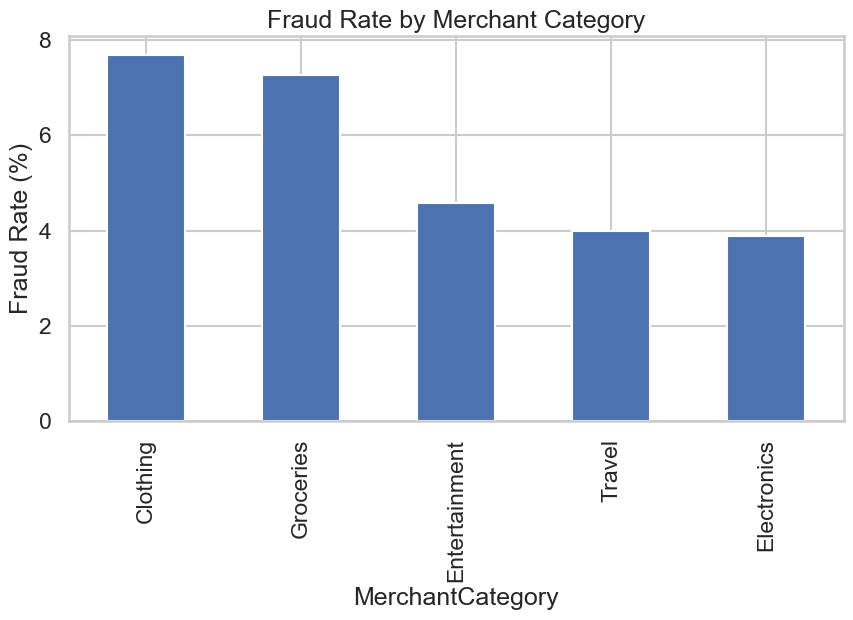

In [57]:
fraud_by_category.plot(kind="bar", figsize=(10,5))
plt.ylabel("Fraud Rate (%)")
plt.title("Fraud Rate by Merchant Category")
plt.show()

In [58]:
df["TimeBucket"] = pd.qcut(
    df["Time"],
    q=4,
    labels=["Early Period", "Mid-Early", "Mid-Late", "Late Period"]
)

fraud_by_time = df.groupby("TimeBucket", observed=True)["IsFraud"].mean() * 100
fraud_by_time


TimeBucket
Early Period   5.60
Mid-Early      5.60
Mid-Late       3.20
Late Period    7.20
Name: IsFraud, dtype: float64

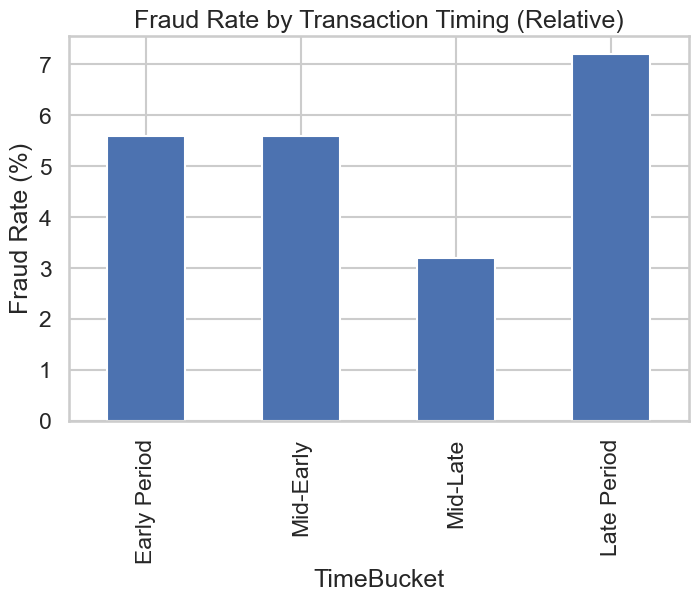

In [59]:
fraud_by_time.plot(kind="bar", figsize=(8,5))
plt.ylabel("Fraud Rate (%)")
plt.title("Fraud Rate by Transaction Timing (Relative)")
plt.show()

In [60]:
df.groupby("IsFraud")["Amount"].describe()

,count,mean,std,min,25%,50%,75%,max
IsFraud,,,,,,,,
0,450.00,651.44,"1,069.76",6.06,250.28,519.91,777.19,"9,691.58"
1,25.00,455.29,311.48,31.47,185.67,371.27,663.84,974.42


In [61]:
total_fraud_loss

11382.17

In [62]:
df.loc[df["IsFraud"] == 1].sort_values("Amount", ascending=False).head(10)


,TransactionID,Amount,Time,Location,MerchantCategory,CardHolderAge,IsFraud,TimeBucket
498,499,974.42,52603,Los Angeles,Electronics,21.00,1,Mid-Late
52,53,939.56,10916,New York,Entertainment,42.00,1,Early Period
112,113,929.77,39811,Miami,Groceries,19.00,1,Mid-Early
228,229,892.15,71158,Chicago,Travel,26.00,1,Late Period
127,128,860.87,80719,Houston,Electronics,45.00,1,Late Period
321,322,714.88,73340,Los Angeles,Entertainment,31.00,1,Late Period
207,208,663.84,12910,NaN,Groceries,21.00,1,Early Period
212,213,652.31,72274,New York,Groceries,35.00,1,Late Period
357,358,586.19,19029,Miami,Entertainment,31.00,1,Mid-Early
496,497,584.07,78623,Miami,Groceries,64.00,1,Late Period


In [63]:
fraud_by_location = (
    df.groupby("Location")["IsFraud"]
    .mean()
    .sort_values(ascending=False) * 100
)
fraud_by_location

Location
Miami         6.73
New York      6.67
Los Angeles   5.15
Chicago       4.81
Houston       3.75
Name: IsFraud, dtype: float64

In [64]:
df["AgeBand"] = pd.cut(
    df["CardHolderAge"],
    bins=[0, 25, 45, 100],
    labels=["<25", "25–45", "45+"],
    include_lowest=True
)

fraud_by_age = (
    df.groupby("AgeBand")["IsFraud"]
    .mean()
    .sort_values(ascending=False) * 100
)

fraud_by_age


C:\Users\aditi\AppData\Local\Temp\ipykernel_26064\1414461454.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("AgeBand")["IsFraud"]


AgeBand
25–45   6.21
<25     4.62
45+     4.44
Name: IsFraud, dtype: float64

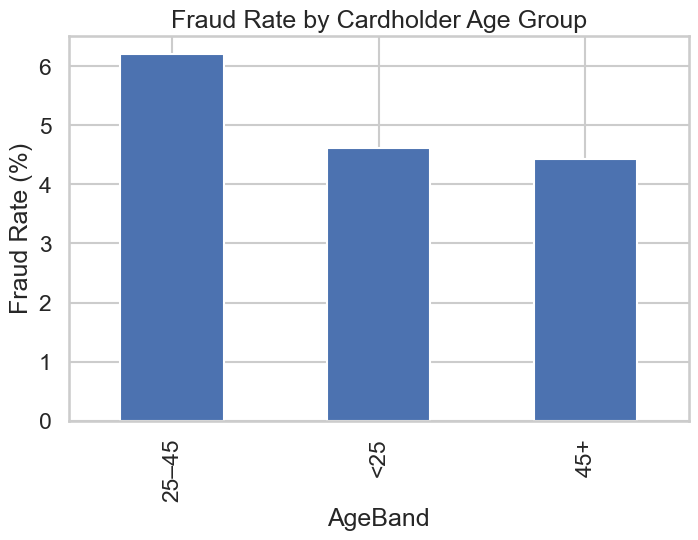

In [65]:
fraud_by_age.plot(kind="bar", figsize=(8,5))
plt.ylabel("Fraud Rate (%)")
plt.title("Fraud Rate by Cardholder Age Group")
plt.show()

In [66]:

high_amount_threshold = df["Amount"].quantile(0.95)

df["HighAmountFlag"] = df["Amount"] >= high_amount_threshold

df["HighAmountFlag"].value_counts()


HighAmountFlag
False    476
True      24
Name: count, dtype: int64

In [67]:
avg_fraud_rate = df["IsFraud"].mean()

high_risk_categories = (
    df.groupby("MerchantCategory", observed=True)["IsFraud"]
    .mean()
    .loc[lambda x: x > avg_fraud_rate]
    .index
)

df["HighRiskCategoryFlag"] = df["MerchantCategory"].isin(high_risk_categories)

high_risk_categories.tolist()


['Clothing', 'Groceries']

In [68]:
fraud_by_time = (
    df.groupby("TimeBucket", observed=True)["IsFraud"]
    .mean()
)

high_risk_time_buckets = fraud_by_time.loc[
    fraud_by_time > fraud_by_time.mean()
].index

df["HighRiskTimeFlag"] = df["TimeBucket"].isin(high_risk_time_buckets)

high_risk_time_buckets.tolist()


['Early Period', 'Mid-Early', 'Late Period']

In [69]:
df["OperationalRiskScore"] = (
    df["HighAmountFlag"].astype(int)
    + df["HighRiskCategoryFlag"].astype(int)
    + df["HighRiskTimeFlag"].astype(int)
)

df["OperationalRiskScore"].value_counts().sort_index()


OperationalRiskScore
0     71
1    275
2    150
3      4
Name: count, dtype: int64

In [70]:
df.loc[df["OperationalRiskScore"] >= 2].sort_values(
    "Amount", ascending=False
).head(10)


,TransactionID,Amount,Time,Location,MerchantCategory,CardHolderAge,IsFraud,TimeBucket,AgeBand,HighAmountFlag,HighRiskCategoryFlag,HighRiskTimeFlag,OperationalRiskScore
359,360,"9,691.58",32265,Miami,Electronics,75.00,0,Mid-Early,45+,True,False,True,2
123,124,"8,694.33",45002,Houston,Clothing,26.00,0,Mid-Late,25–45,True,True,False,2
455,456,"8,293.59",70480,Chicago,Clothing,51.00,0,Late Period,45+,True,True,True,3
306,307,"7,974.24",15524,New York,Entertainment,45.00,0,Early Period,25–45,True,False,True,2
120,121,"7,839.87",69836,Miami,Groceries,26.00,0,Late Period,25–45,True,True,True,3
253,254,"5,862.62",79239,New York,Electronics,77.00,0,Late Period,45+,True,False,True,2
325,326,"5,516.33",9184,Chicago,Clothing,75.00,0,Early Period,45+,True,True,True,3
475,476,992.97,27952,Miami,Travel,71.00,0,Mid-Early,45+,True,False,True,2
69,70,986.90,7239,Miami,Travel,52.00,0,Early Period,45+,True,False,True,2
499,500,986.22,81974,Chicago,Electronics,37.00,0,Late Period,25–45,True,False,True,2


In [71]:
df.groupby("OperationalRiskScore", observed=True)["IsFraud"].mean() * 100


OperationalRiskScore
0   2.82
1   4.36
2   8.67
3   0.00
Name: IsFraud, dtype: float64